In [1]:
#!pip install cr-sparse scikit-image

In [2]:
from jax.config import config
config.update("jax_enable_x64", True)

In [3]:
import jax.numpy as jnp
from cr.sparse import lop
import cr.sparse as crs
import cr.sparse.vision as vision
import cr.sparse.sls as sls
import cr.sparse.geo as geo
from cr.sparse import metrics
import skimage.data

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

(512, 512)

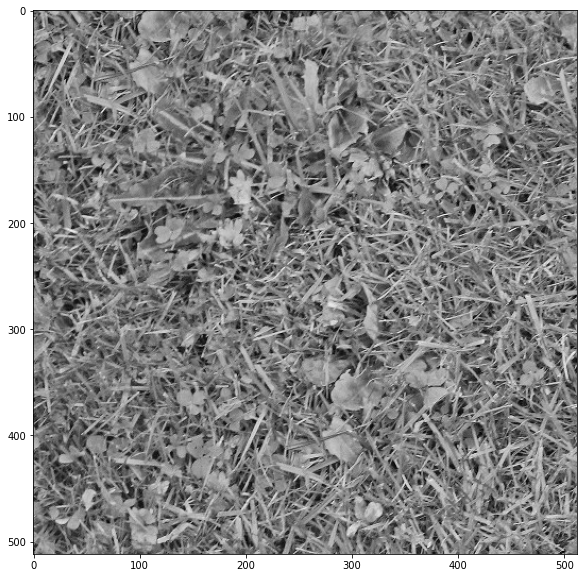

In [5]:
image = skimage.data.grass()
image = jnp.array(image)
fig, ax = plt.subplots(ncols=1, figsize=(10, 10))
ax.imshow(image, cmap=plt.cm.gray)
image.shape

(-0.5, 24.5, 14.5, -0.5)

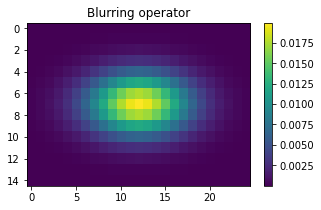

In [6]:
h  = vision.kernel_gaussian((15,25), (8,4))
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
him = ax.imshow(h)
ax.set_title('Blurring operator')
fig.colorbar(him, ax=ax)
ax.axis('tight')

In [7]:
offset = crs.arr_largest_index(h)
offset

(7, 12)

In [8]:
# The blur operator using CR-Sparse
Blur = lop.convolve2D(image.shape, h, offset=offset)
Blur = lop.jit(Blur)

In [9]:
blurred = Blur.times(image)

In [10]:
print(metrics.peak_signal_noise_ratio(image, blurred), 'dB')

18.392461372355466 dB


Text(0.5, 1.0, 'After blurring')

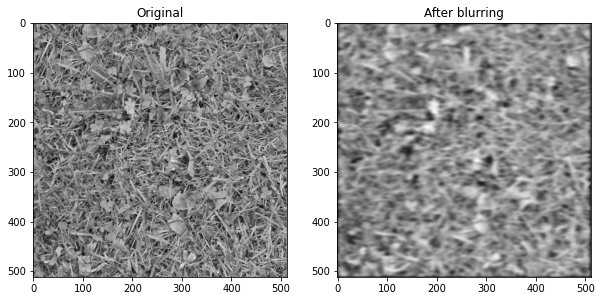

In [11]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].set_title('Original')
ax[1].imshow(blurred, cmap=plt.cm.gray)
ax[1].set_title('After blurring')

Text(0.5, 1.0, 'Wavelet coefficients')

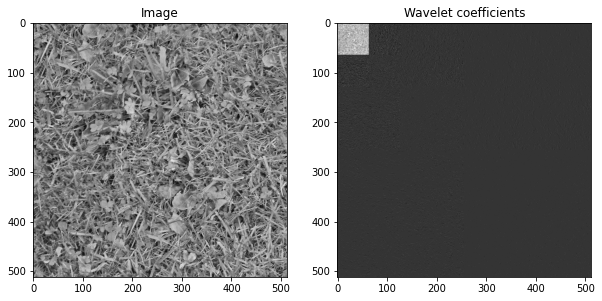

In [12]:
DWT_basis = lop.dwt2D(image.shape, wavelet='haar', level=3, basis=True)
DWT_basis = lop.jit(DWT_basis)
# Visualize the wavelet transform of the image
coefs = DWT_basis.trans(image)
fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].set_title('Image')
ax[1].imshow(coefs, cmap=plt.cm.gray)
ax[1].set_title('Wavelet coefficients')

In [13]:
A = Blur @ DWT_basis

In [14]:
# Step size for the FISTA algorithm
step_size = 1.

In [15]:
# Thresholding function for the FISTA algorithm
threshold_func = lambda i, x : geo.soft_threshold(x, 0.02)

In [16]:
# Initial guess for the wavelet coefficients matrix is all zeros
x0 = jnp.zeros(DWT_basis.shape[1])

In [17]:
# Solve the \| A x - b \|_2^2 + \lambda \| x \|_1 problem
sol = sls.fista_jit(
    # The combined convolution+wavelet basis operator
    A,
    # The blurred image as input
    b=blurred,
    # Initial guess for the coefficients
    x0=x0,
    # Step size for the FISTA algorithm
    step_size=1.,
    # Thresholding function to be used for FISTA
    threshold_func=threshold_func,
    # Maximum number of iterations for which the algorithm will be run
    max_iters=50)

In [18]:
print(f"Number of FISTA iterations {sol.iterations}")

Number of FISTA iterations 50


In [19]:
# Compute the deblurred image from the coefficients given by FISTA
deblurred = DWT_basis.times(sol.x)

In [20]:
# Measure the PSNR
print("Deblurred PSNR: ", metrics.peak_signal_noise_ratio(image, deblurred), 'dB')

Deblurred PSNR:  20.29986250537029 dB


Text(0.5, 1.0, 'FISTA deblurring')

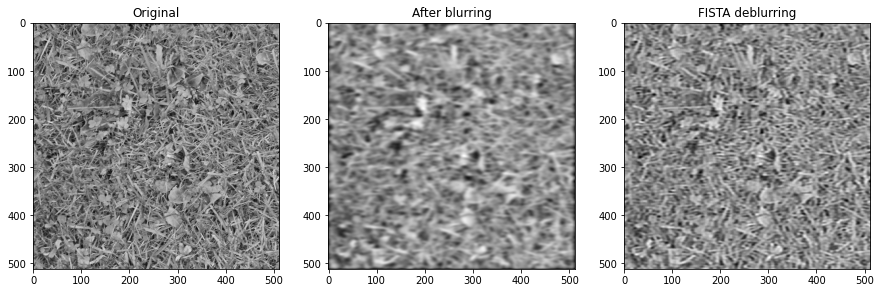

In [21]:
fig, ax = plt.subplots(ncols=3, figsize=(15, 5))
ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].set_title('Original')
ax[1].imshow(blurred, cmap=plt.cm.gray)
ax[1].set_title('After blurring')
ax[2].imshow(deblurred, cmap=plt.cm.gray)
ax[2].set_title('FISTA deblurring')